# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: ROICaT
python version: 3.9.13


In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import natsort

import torch

import gc
import time
import functools
import multiprocessing as mp


In [3]:
tic = time.time()
toc = {}
toc['start'] = time.time() - tic

In [4]:
%load_ext autoreload
%autoreload 2
import roicat
# from roicat import helpers, data_importing, ROInet
# from roicat.tracking import alignment, blurring, clustering, scatteringWaveletTransformer, similarity_graph, visualization

In [5]:
from bnpm import file_helpers

In [6]:
%matplotlib notebook

# Import paths

In [9]:
# dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16").resolve()
# dir_allOuterFolders = Path(r"/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files").resolve()
# dir_allOuterFolders = str(Path(r"/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/Sofia_ROIs/Data for Rich/SS33/").resolve())
dir_allOuterFolders = str(Path(r"/media/rich/bigSSD/analysis_data/statFiles_mouse_1511L").resolve())

# folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])[:]

# dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_allSessions]

pathSuffixToStat = 'stat.npy'
pathSuffixToOps = 'ops.npy'
# pathSuffixToStat = 'Slice02/stat.npy'
# pathSuffixToOps = 'Slice02/ops.npy'

# paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
paths_allStat = test = roicat.helpers.find_paths(
    dir_outer=dir_allOuterFolders,
    reMatch=pathSuffixToStat,
    depth=4,
)
# paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]
paths_allOps = test = roicat.helpers.find_paths(
    dir_outer=dir_allOuterFolders,
    reMatch=pathSuffixToOps,
    depth=4,
)
# paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])
# paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])

# print(f'folder names of all sessions: \n{display(folders_allSessions)}')
print(f'paths to all stat files:');
[print(path) for path in paths_allStat];
print('');
print(f'paths to all ops files:');
[print(path) for path in paths_allOps];


paths to all stat files:
/media/rich/bigSSD/analysis_data/statFiles_mouse_1511L/20230111/stat.npy
/media/rich/bigSSD/analysis_data/statFiles_mouse_1511L/20230112/stat.npy
/media/rich/bigSSD/analysis_data/statFiles_mouse_1511L/20230113/stat.npy
/media/rich/bigSSD/analysis_data/statFiles_mouse_1511L/20230114/stat.npy
/media/rich/bigSSD/analysis_data/statFiles_mouse_1511L/20230115/stat.npy
/media/rich/bigSSD/analysis_data/statFiles_mouse_1511L/20230116/stat.npy
/media/rich/bigSSD/analysis_data/statFiles_mouse_1511L/20230117/stat.npy
/media/rich/bigSSD/analysis_data/statFiles_mouse_1511L/20230118/stat.npy
/media/rich/bigSSD/analysis_data/statFiles_mouse_1511L/20230119/stat.npy

paths to all ops files:
/media/rich/bigSSD/analysis_data/statFiles_mouse_1511L/20230111/ops.npy
/media/rich/bigSSD/analysis_data/statFiles_mouse_1511L/20230112/ops.npy
/media/rich/bigSSD/analysis_data/statFiles_mouse_1511L/20230113/ops.npy
/media/rich/bigSSD/analysis_data/statFiles_mouse_1511L/20230114/ops.npy
/medi

In [10]:
toc['import_paths'] = time.time() - tic

# Import data

In [11]:
toc['import_data'] = time.time() - tic

In [12]:
data = roicat.data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=2.0,
    new_or_old_suite2p='new',

    out_height_width=[36,36],
    
    type_meanImg='meanImgE',

    verbose=True,
)

assert data.check_completeness(verbose=False)['tracking'], f"Data object is missing attributes necessary for tracking."

Starting: Importing FOV images from ops files
Completed: Set FOV_height and FOV_width successfully.
Completed: Imported 9 FOV images.
Completed: Set FOV_images for 9 sessions successfully.
Importing spatial footprints from stat files.


100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s]


Imported 9 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 9 sessions successfully.
Completed: Created sessionID_concat.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


<IPython.core.display.Javascript object>


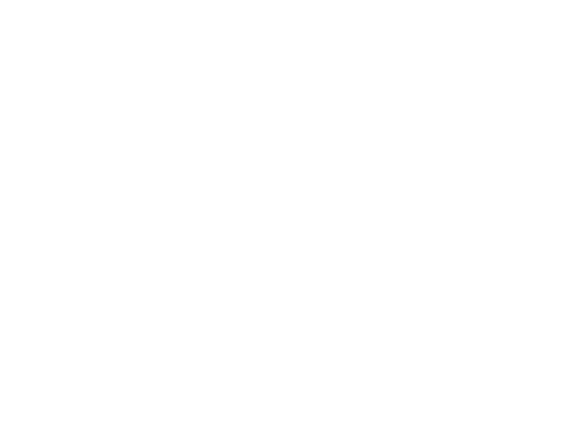

interactive(children=(IntSlider(value=0, description='i_frame', max=8), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


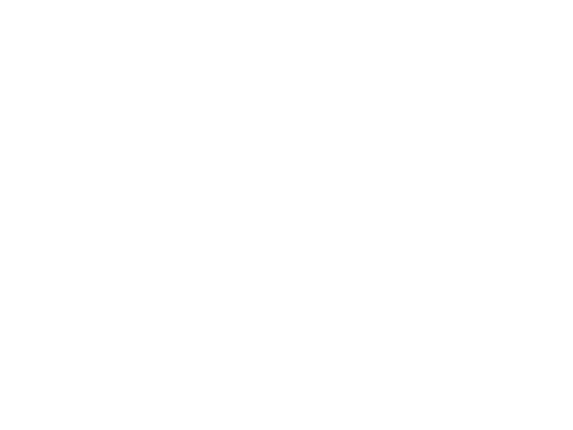

interactive(children=(IntSlider(value=0, description='i_frame', max=8), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


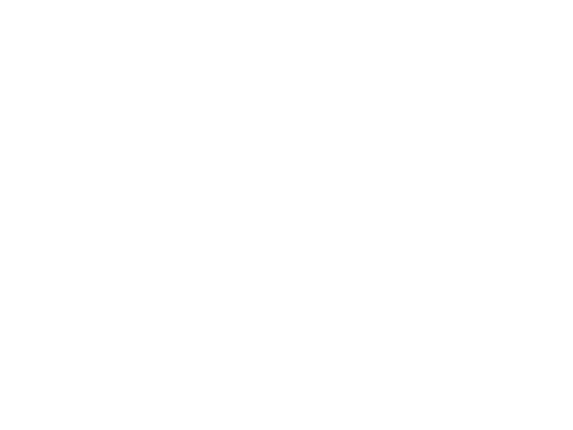

interactive(children=(IntSlider(value=0, description='i_frame', max=29526), Output()), _dom_classes=('widget-i…

In [13]:
%matplotlib notebook

roicat.tracking.visualization.display_toggle_image_stack(data.FOV_images)

roicat.tracking.visualization.display_toggle_image_stack([sf.max(0).reshape(data.FOV_height, data.FOV_width).toarray() for sf in data.spatialFootprints], clim=[0,0.1])

roicat.tracking.visualization.display_toggle_image_stack(np.concatenate(data.ROI_images, axis=0))

# Alignment

In [14]:
use_CLAHE = True
idx_session_template = 0.5
idx_st = int(idx_session_template * data.n_sessions) if type(idx_session_template) is float else idx_session_template

FOV_images = [roicat.tracking.alignment.clahe(im, grid_size=10, clipLimit=0, normalize=True) for im in data.FOV_images] if use_CLAHE else data.FOV_images

pcr = roicat.tracking.alignment.PhaseCorrelation_registration()

pcr.set_spectral_mask(
    freq_highPass=0.01,
    freq_lowPass=0.3,
    im_shape=(data.FOV_height, data.FOV_width)
)

pcr.register(
    template=FOV_images[idx_st],
    ims_moving=FOV_images,
    template_method='image',
);

aligner = roicat.tracking.alignment.Alinger(
    method='createOptFlow_DeepFlow',
    kwargs_method=None
)

aligner.register_ROIs(
    template=pcr.ims_registered[idx_st],
    FOVs=pcr.ims_registered,
    ROIs=data.spatialFootprints,
    template_method='image',
    shifts=pcr.shifts[:],
    return_sparse=True,
    normalize=True,
);

Finding optical flow fields between FOVs using image template...


100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.98it/s]


Registering ROIs...


100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [02:57<00:00, 19.77s/it]


<IPython.core.display.Javascript object>


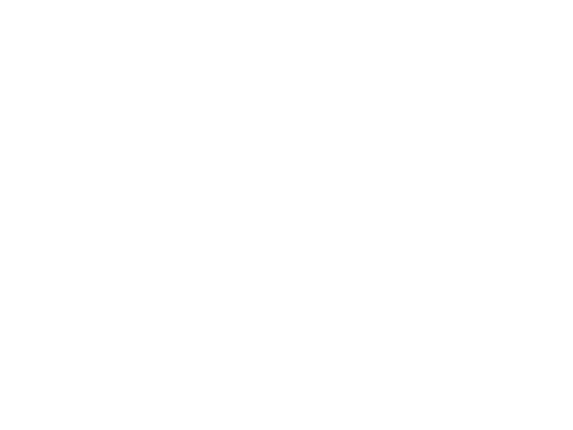

interactive(children=(IntSlider(value=0, description='i_frame', max=8), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


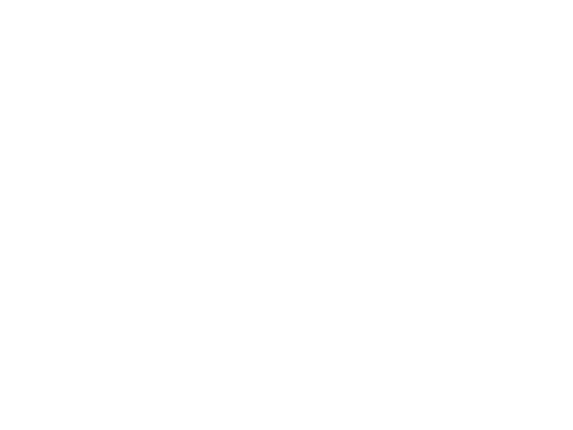

interactive(children=(IntSlider(value=0, description='i_frame', max=8), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


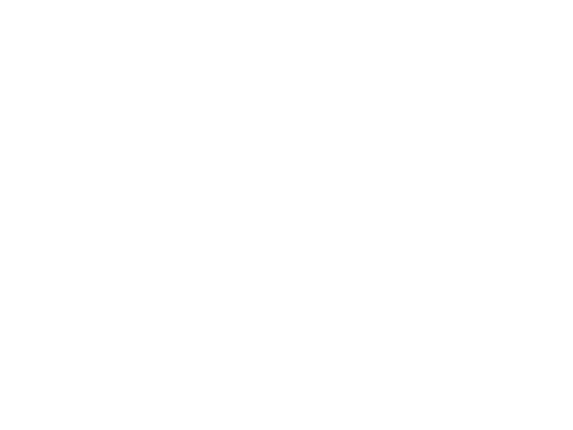

interactive(children=(IntSlider(value=0, description='i_frame', max=8), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


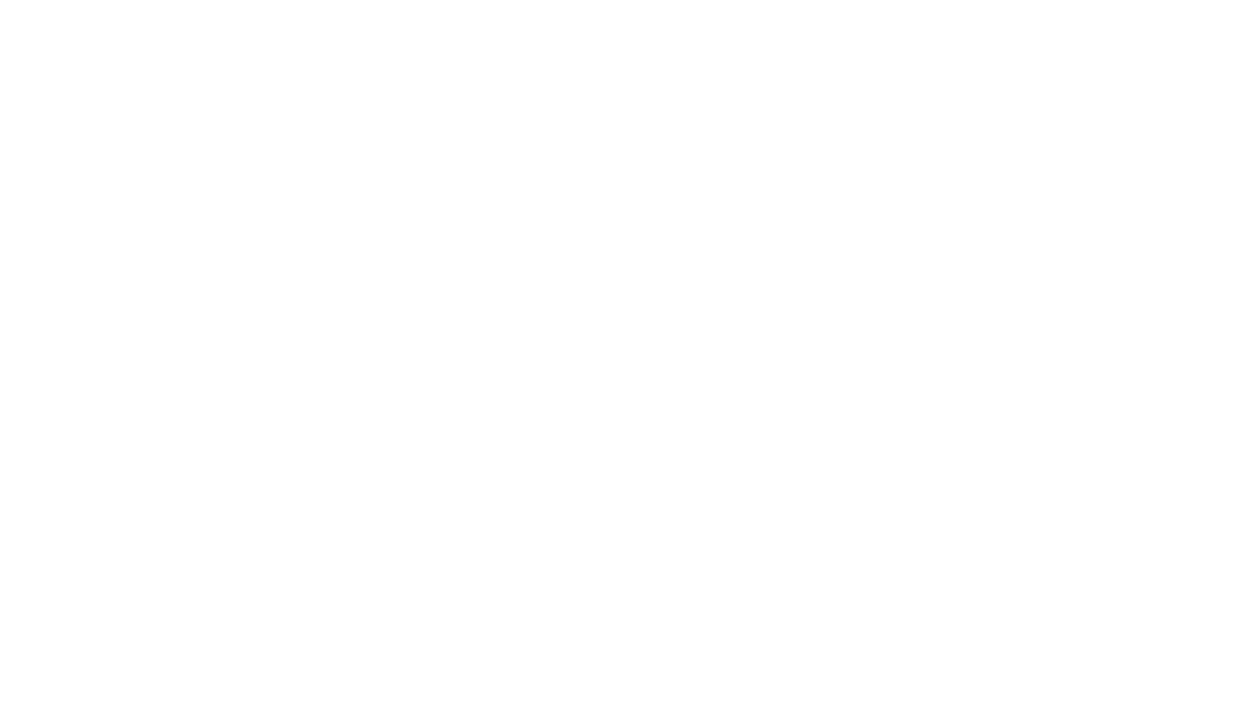

interactive(children=(IntSlider(value=0, description='i_frame', max=8), Output()), _dom_classes=('widget-inter…

In [15]:
%matplotlib notebook

roicat.tracking.visualization.display_toggle_image_stack(pcr.ims_registered[:])

roicat.tracking.visualization.display_toggle_image_stack(aligner.FOVs_aligned)
roicat.tracking.visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection(), clim=[0,0.03])
roicat.tracking.visualization.display_toggle_2channel_image_stack(aligner.flows)

In [16]:
toc['alignment'] = time.time() - tic

## Blur ROIs (optional)

In [17]:
blurrer = roicat.tracking.blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=2,
    plot_kernel=False,
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned[:],
)

Preparing the Toeplitz convolution matrix
Performing convolution for blurring


<IPython.core.display.Javascript object>


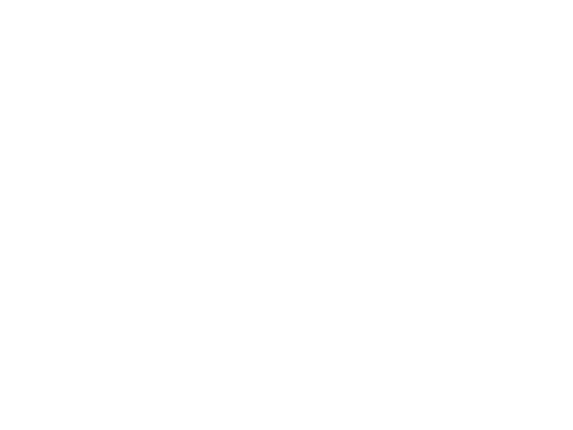

interactive(children=(IntSlider(value=0, description='i_frame', max=8), Output()), _dom_classes=('widget-inter…

In [18]:
%matplotlib notebook
roicat.tracking.visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

In [19]:
toc['blur'] = time.time() - tic

## Neural network embedding distances

In [20]:
roinet = roicat.ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles=r'/home/rich/Desktop/tmp_data/',
    download_method='check_local_first',
    download_url='https://osf.io/pkc2x/download',
    download_hash='1e62893d8e944819516e793656afc31d',
    forward_pass_version='latent',
    verbose=True,
)

File already exists locally: /home/rich/Desktop/tmp_data/ROInet.zip
Hash of local file matches provided hash_hex.
Extracting /home/rich/Desktop/tmp_data/ROInet.zip to /home/rich/Desktop/tmp_data.
Completed zip extraction.
Imported model from /home/rich/Desktop/tmp_data/ROInet_tracking_20220527/model.py
Loaded params_model from /home/rich/Desktop/tmp_data/ROInet_tracking_20220527/params.json


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /home/rich/Desktop/tmp_data/ROInet_tracking_20220527/ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda:0


In [21]:
roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    

#     batchSize_dataloader=1,
#     pinMemory_dataloader=False,
#     numWorkers_dataloader=0,
#     persistentWorkers_dataloader=False,
#     prefetchFactor_dataloader=2,    
);

Starting: resizing ROIs
Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader


<IPython.core.display.Javascript object>


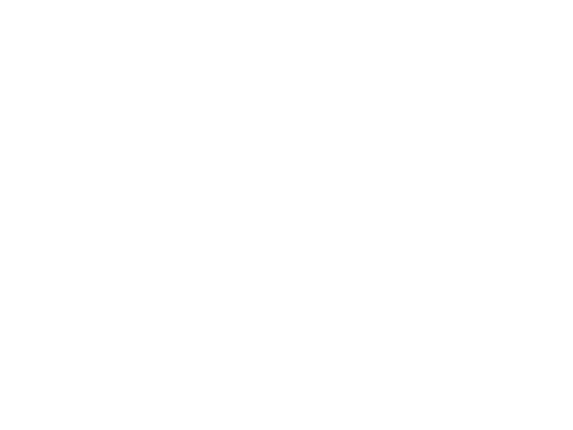

interactive(children=(IntSlider(value=0, description='i_frame', max=29526), Output()), _dom_classes=('widget-i…

In [22]:
%matplotlib notebook
roicat.tracking.visualization.display_toggle_image_stack(roinet.ROI_images_rs)

In [23]:
roinet.generate_latents();


starting: running data through network


  0%|                                                                                     | 0/3691 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: o

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggere

completed: running data through network


In [24]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [25]:
toc['NN'] = time.time() - tic

## Scattering wavelet embedding distances

In [26]:
swt = roicat.tracking.scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 2}, 
    image_shape=data.ROI_images[0].shape[1:3], 
    device='cuda:0'
)

swt.transform(
    ROI_images=np.concatenate(data.ROI_images, axis=0),
    batch_size=100,
);

SWT initialized
Starting: SWT transform on ROIs


296it [00:00, 379.59it/s]                                                                                          

Completed: SWT transform on ROIs


In [27]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()


In [28]:
toc['SWT'] = time.time() - tic

## Compute similarities

<IPython.core.display.Javascript object>


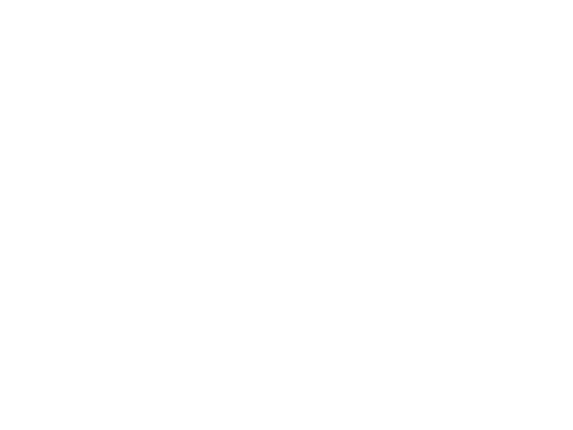

Computing pairwise similarity between ROIs...


100%|██████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.88it/s]


Joining blocks into full similarity matrices...
Joining s_sf...


8719it [00:06, 1282.16it/s]                                                                                        


Joining s_NN...


8719it [00:06, 1271.69it/s]                                                                                        


Joining s_SWT...


8719it [00:06, 1316.28it/s]                                                                                        


Joining s_sesh...


8719it [00:06, 1254.86it/s]                                                                                        


In [29]:
sim = roicat.tracking.similarity_graph.ROI_graph(
    n_workers=-1,
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
#     block_height=data.FOV_height,
#     block_width=data.FOV_width,
    block_height=128,
    block_width=128,
    algorithm_nearestNeigbors_spatialFootprints='brute',
    verbose=True,
)

sim.visualize_blocks()

s_sf, s_NN, s_SWT, s_sesh = sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,
#     spatialFootprints=aligner.ROIs_aligned,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    spatialFootprint_maskPower=1.0,
);

In [30]:
sim.make_normalized_similarities(
    centers_of_mass=data.centroids,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
#     features_SWT=None,
    k_max=4000,
    k_min=100,
    algo_NN='kd_tree',
    device='cuda:0'
)

toc['sim'] = time.time() - tic

Finding k-range of center of mass distance neighbors for each ROI...
Normalizing Neural Network similarity scores...


100%|█████████████████████████████████████████████████████████████████████| 29527/29527 [00:02<00:00, 14001.36it/s]


Normalizing SWT similarity scores...


100%|█████████████████████████████████████████████████████████████████████| 29527/29527 [00:02<00:00, 11229.32it/s]


# Clustering

Finding mixing parameters using automated hyperparameter tuning...
Best value found: 0.06507518887519836 with parameters {'power_SF': 0.8810470976633143, 'power_NN': 1.8334720532450173, 'power_SWT': 0.2552218250484988, 'p_norm': -3.3725222495498013, 'sig_SF_kwargs': None, 'sig_NN_kwargs': {'mu': 0.44087315811216926, 'b': 0.12348395179751243}, 'sig_SWT_kwargs': {'mu': 0.24404192864659774, 'b': 1.9861676154594596}}


<IPython.core.display.Javascript object>


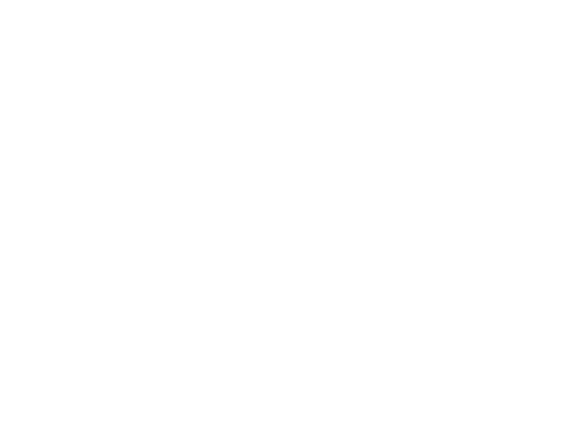

<IPython.core.display.Javascript object>


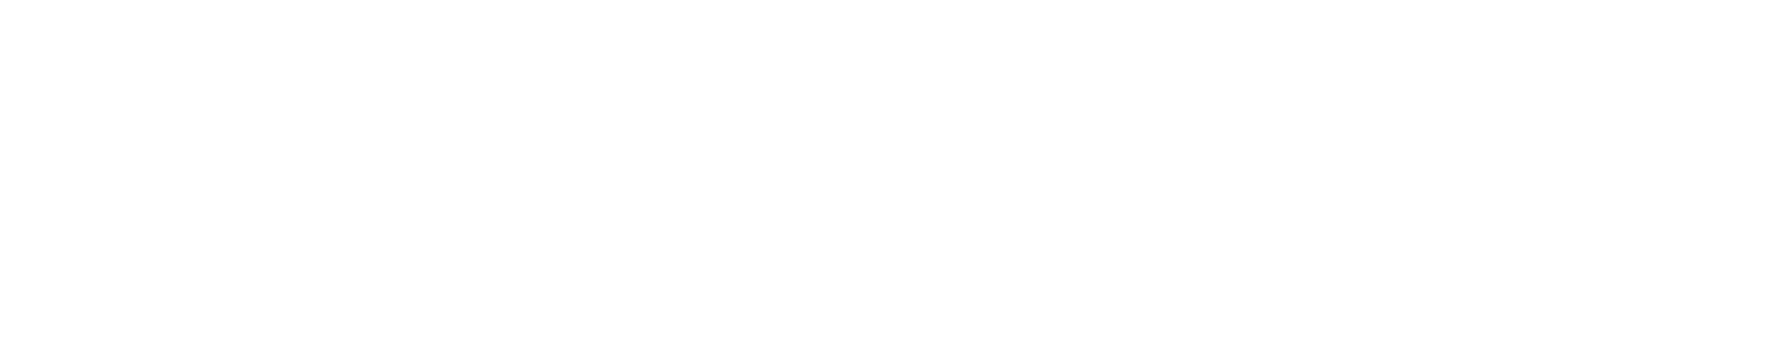

In [31]:
clusterer = roicat.tracking.clustering.Clusterer(
    s_sf=sim.s_sf,
    s_NN_z=sim.s_NN_z,
    s_SWT_z=sim.s_SWT_z,
    s_sesh=sim.s_sesh,
)

kwargs_makeConjunctiveDistanceMatrix_best = clusterer.find_optimal_parameters_for_pruning(
    n_bins=50,
    find_parameters_automatically=True,
    kwargs_findParameters={
        'n_patience': 100,
        'tol_frac': 0.05,
        'max_trials': 350,
        'max_duration': 60*10,
        'verbose': False,
    },
    bounds_findParameters={
        'power_SF': (0.3, 2),
        'power_NN': (0.2, 2),
        'power_SWT': (0.1, 1),
        'p_norm': (-5, 5),
        'sig_NN_kwargs_mu': (0, 0.5),
        'sig_NN_kwargs_b': (0.05, 2),
        'sig_SWT_kwargs_mu': (0, 0.5),
        'sig_SWT_kwargs_b': (0.05, 2),
    },
    n_jobs_findParameters=-1,    
#     fallback_d_cutoff=0.5,
#     plot_pref=True,
)

toc['separate_diffSame'] = time.time() - tic

clusterer.plot_distSame()

clusterer.plot_similarity_relationships(
    plots_to_show=[1,2,3], 
    max_samples=100000, 
    kwargs_scatter={'s':1, 'alpha':0.2},
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
#     kwargs_makeConjunctiveDistanceMatrix={
#         'power_SF': 1.0,
#         'power_NN': 1.0,
#         'power_SWT': 0.1,
#         'p_norm': -4.0,
#         'sig_SF_kwargs': {'mu':0.5, 'b':4},
# #         'sig_SF_kwargs': None,
#         'sig_NN_kwargs': {'mu':0.5, 'b':1.5},
#         'sig_SWT_kwargs': {'mu':0.5, 'b':0.5},
#     },
);

In [32]:
clusterer.make_pruned_similarity_graphs(
    d_cutoff=None,
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best
)

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [33]:
if data.n_sessions >= 8:
    labels = clusterer.fit(
        session_bool=data.sessionID_concat,
        min_cluster_size=2,
        cluster_selection_method='leaf',
        d_clusterMerge=None,
        alpha=0.999,
        n_iter_violationCorrection=6,
        d_conj=None,
        kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
    #     kwargs_makeConjunctiveDistanceMatrix={
    #         'power_SF': 1.0,
    #         'power_NN': 1.0,
    #         'power_SWT': 0.1,
    #         'p_norm': -2,
    #         'sig_SF_kwargs': None,
    #         'sig_NN_kwargs':  {'mu':0, 'b':0.2},
    #         'sig_SWT_kwargs': {'mu':0, 'b':0.2},
    #     },
        split_intraSession_clusters=True,
        discard_failed_pruning=True,
        d_step=0.01,
    )

else:
    labels = clusterer.fit_sequentialHungarian(
        session_bool=data.sessionID_concat,
        thresh_cost=0.6,
        d_conj=None,
        kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
    #     kwargs_makeConjunctiveDistanceMatrix={
    #     'power_SF': 1.0,
    #     'power_NN': 1.0,
    #     'power_SWT': 0.1,
    #     'p_norm': -2,
    #     'sig_SF_kwargs': None,
    #     'sig_NN_kwargs':  {'mu':0, 'b':0.2},
    #     'sig_SWT_kwargs': {'mu':0, 'b':0.2},
    #     },
    )

labels_bySession = [labels[idx] for idx in data.sessionID_concat.T]

Fitting with HDBSCAN and splitting clusters with multiple ROIs per session


  0%|                                                                                        | 0/6 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [02:32<00:00, 25.37s/it]


In [34]:
## results_clustering
print(f'Number of clusters: {len(np.unique(labels))}')
print(f'Number of discarded ROIs: {(labels==-1).sum()}')

Number of clusters: 4573
Number of discarded ROIs: 8084


In [35]:
toc['clustering'] = time.time() - tic

# Visualize results

In [36]:
FOV_clusters = roicat.tracking.visualization.compute_colored_FOV(
    spatialFootprints=[r.power(0.7) for r in aligner.ROIs_aligned],
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    boolSessionID=data.sessionID_concat,
    labels=labels,
    confidence=None,
)

<IPython.core.display.Javascript object>


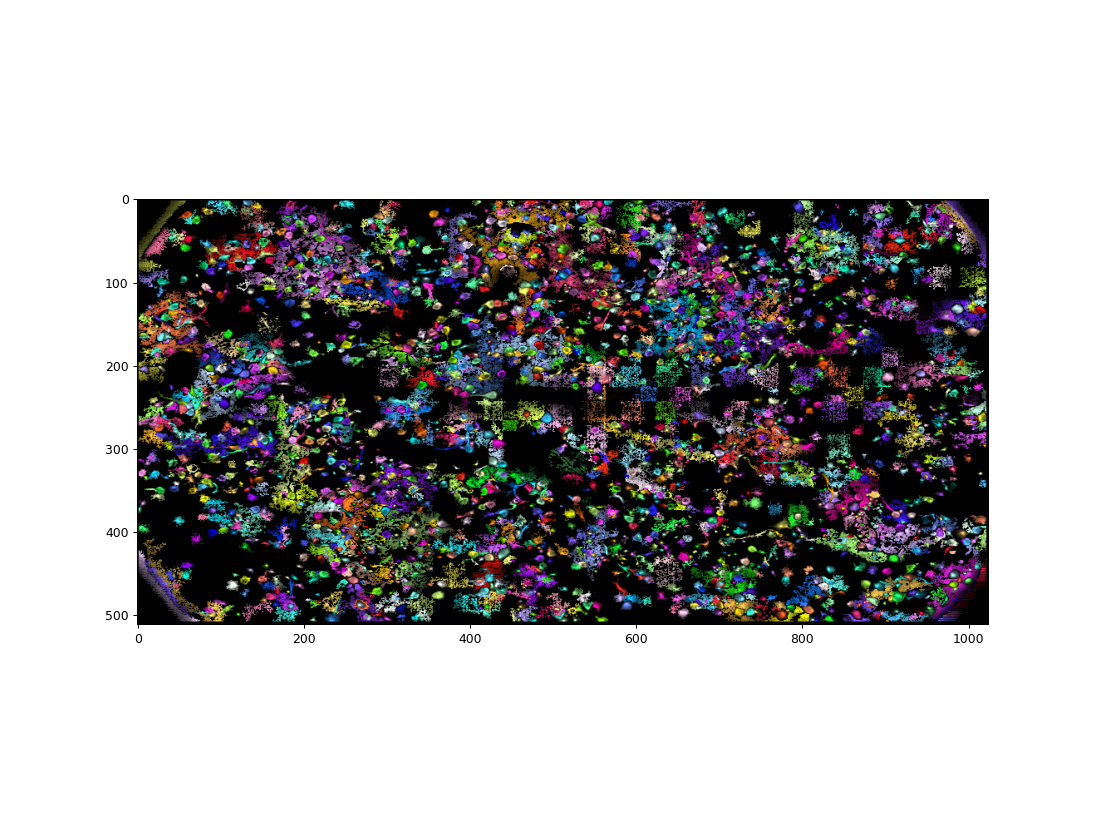

interactive(children=(IntSlider(value=0, description='i_frame', max=8), Output()), _dom_classes=('widget-inter…

In [46]:
%matplotlib notebook
roicat.tracking.visualization.display_toggle_image_stack(
    FOV_clusters, 
#     interpolation='none', 
#     filternorm=False, 
#     resample=False
)

In [38]:
# visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

/tmp/ipykernel_640738/3994115036.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(40,1))


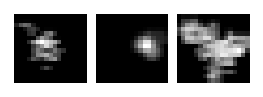

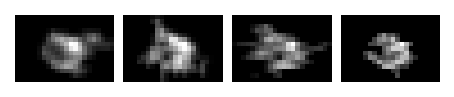

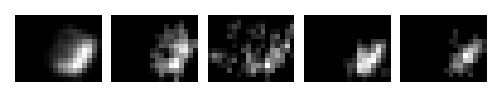

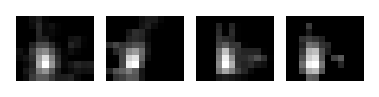

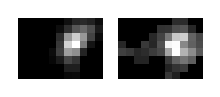

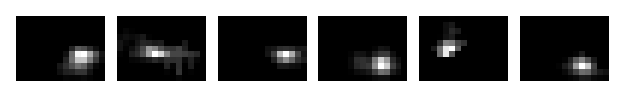

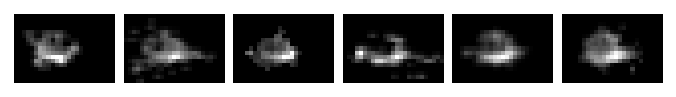

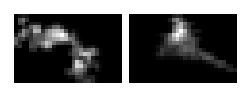

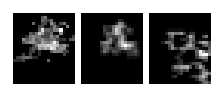

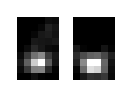

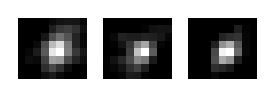

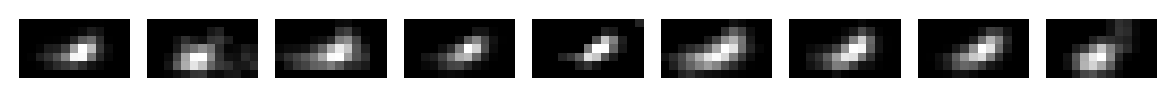

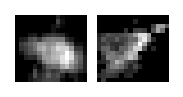

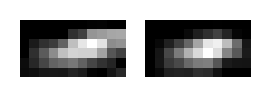

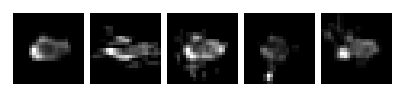

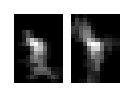

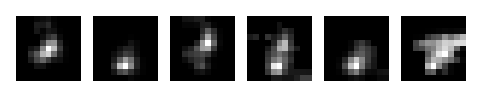

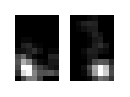

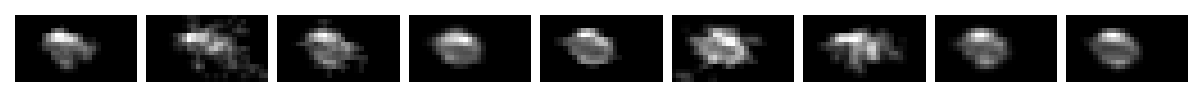

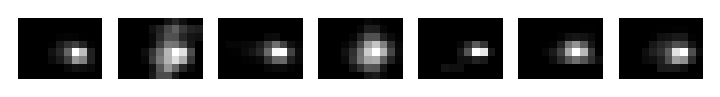

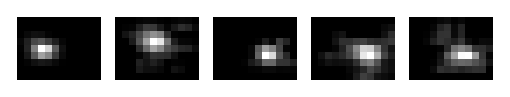

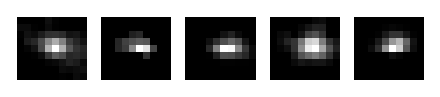

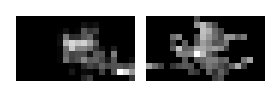

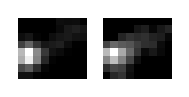

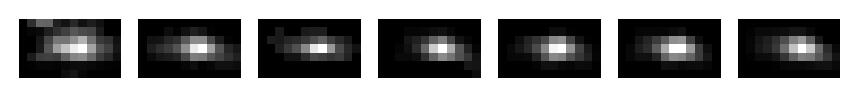

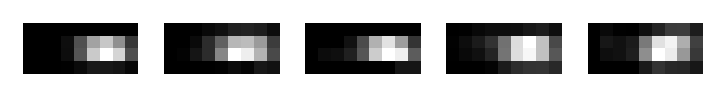

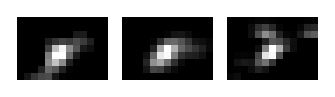

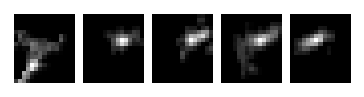

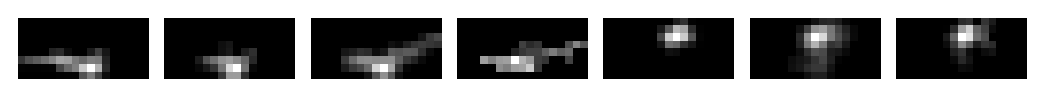

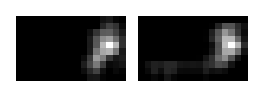

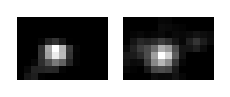

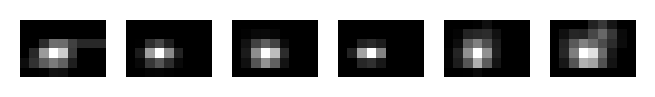

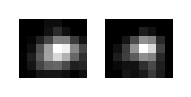

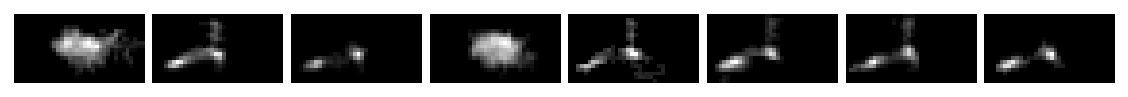

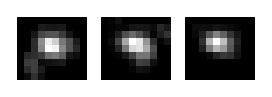

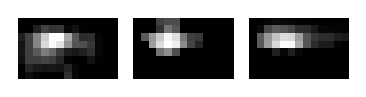

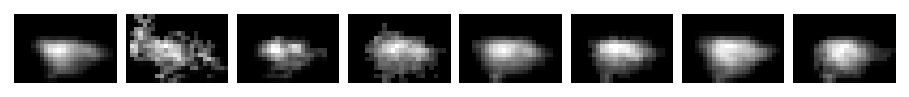

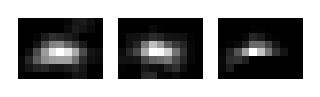

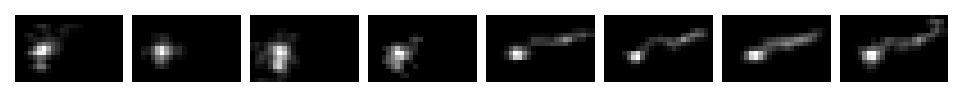

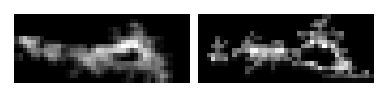

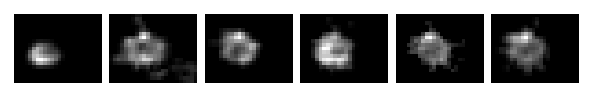

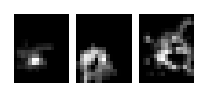

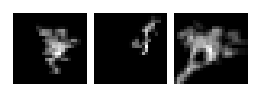

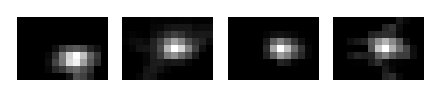

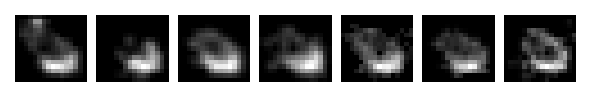

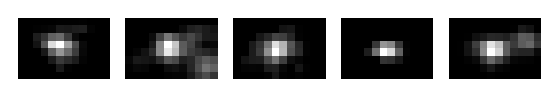

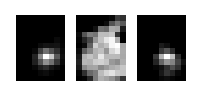

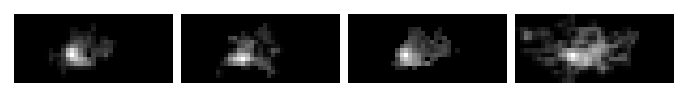

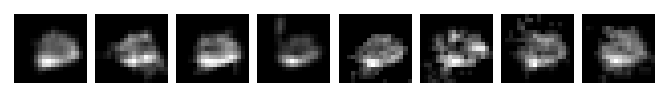

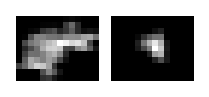

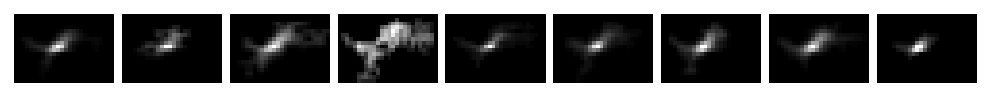

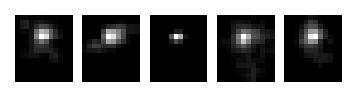

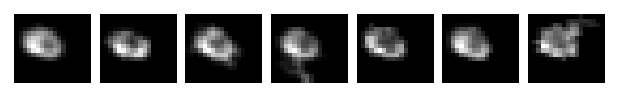

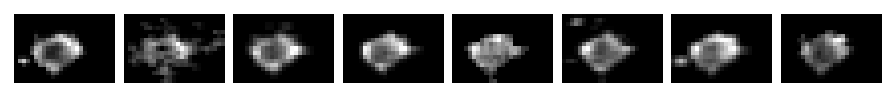

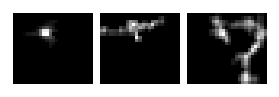

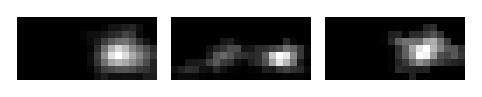

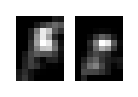

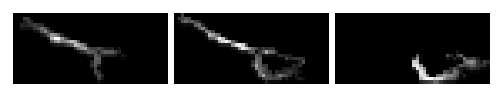

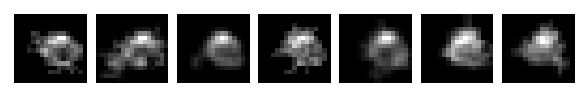

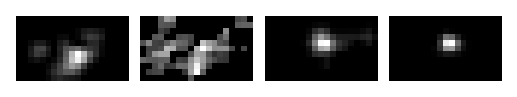

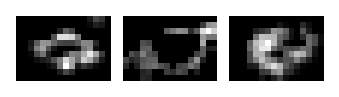

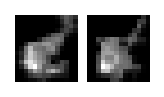

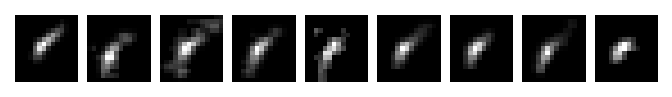

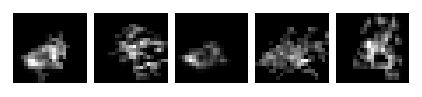

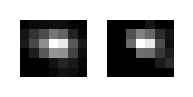

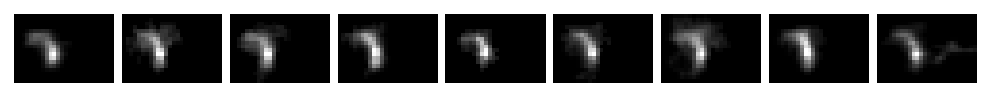

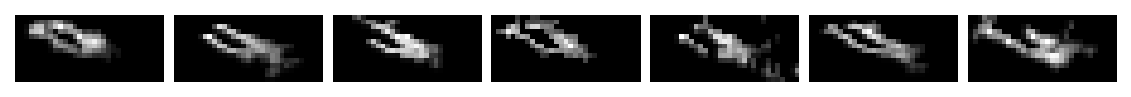

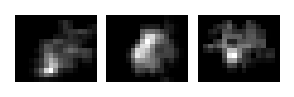

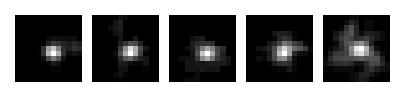

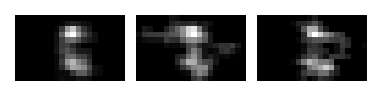

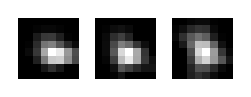

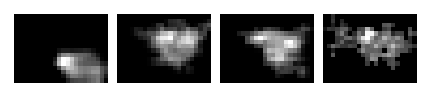

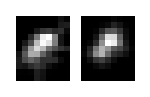

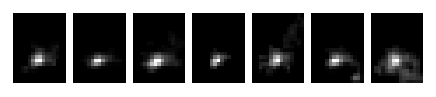

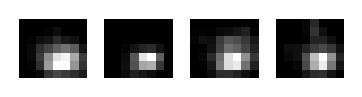

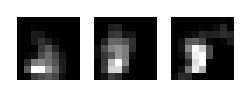

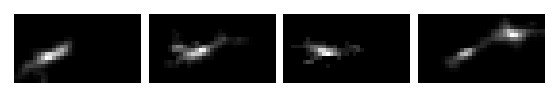

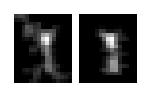

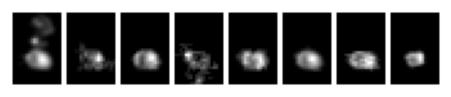

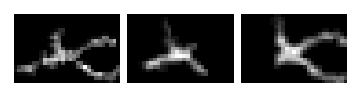

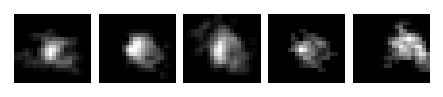

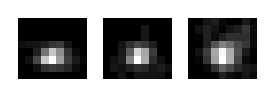

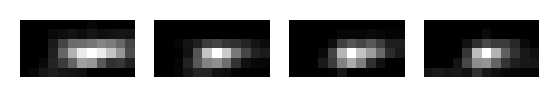

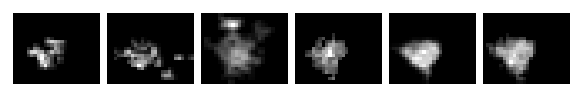

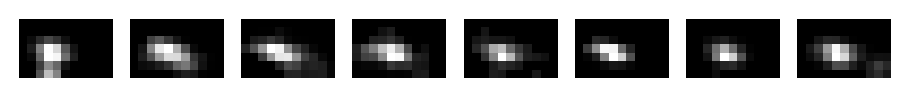

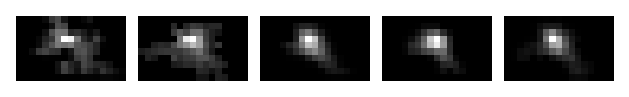

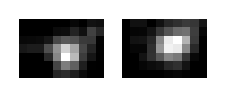

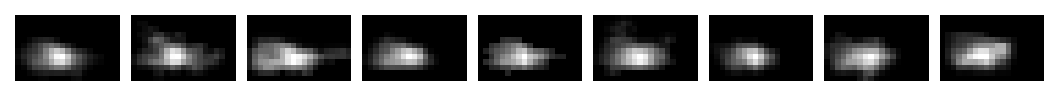

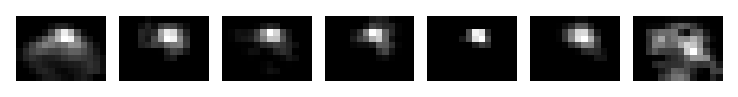

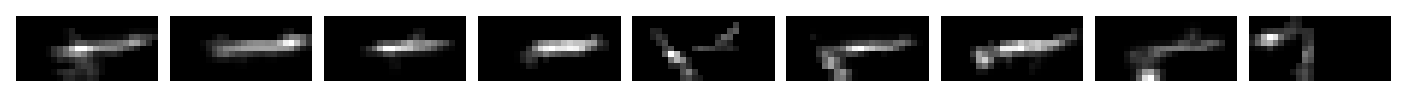

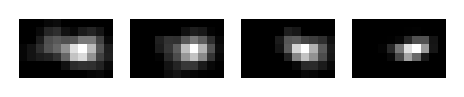

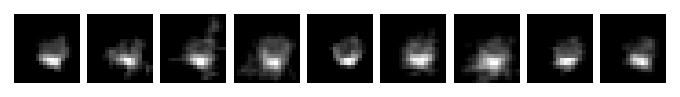

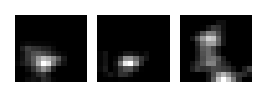

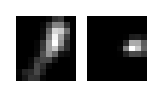

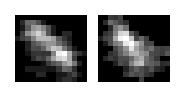

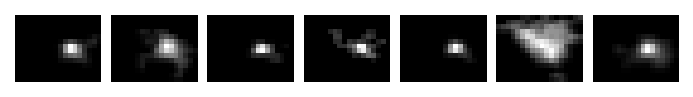

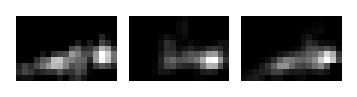

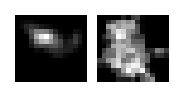

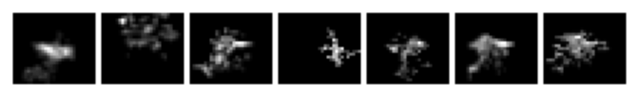

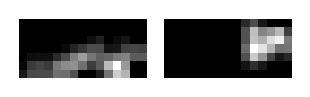

In [39]:
import scipy.sparse

ucids = labels.copy()
# ucids = ucids[ucids==975]
ucids_unique = np.unique(ucids[ucids>-1])

# ROI_ims = np.concatenate(data.ROI_images, axis=0)
ROI_ims_sparse = scipy.sparse.vstack(aligner.ROIs_aligned)
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()


ucid_sfCat = []
for ucid in ucids_unique:
    idx = np.where(ucids == ucid)[0]
    ucid_sfCat.append( np.concatenate(list(roicat.tracking.visualization.crop_cluster_ims(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width))), axis=1) )
#     ucid_sfCat.append( np.concatenate(list(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width)), axis=1) )
# data.ROI_images[i_sesh][idx] for 


%matplotlib inline

for sf in ucid_sfCat[:100]:
    plt.figure(figsize=(40,1))
    plt.imshow(sf, cmap='gray')
    plt.axis('off')

<IPython.core.display.Javascript object>


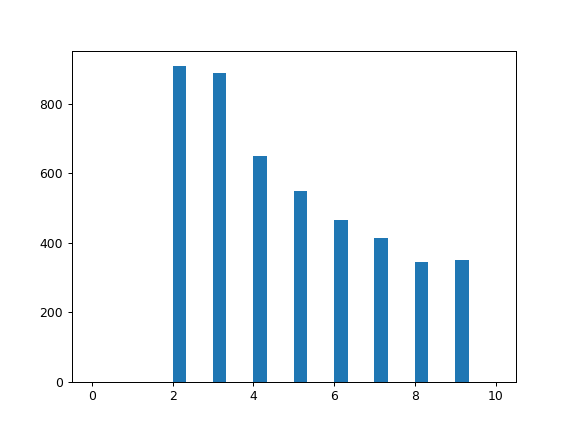

In [40]:
%matplotlib notebook

_, counts = np.unique(labels, return_counts=True)

plt.figure()
plt.hist(counts, 30, range=(0, data.n_sessions+1));


In [41]:
toc['visualize'] = time.time() - tic

# Save results

In [42]:
dir_save = Path('/home/rich/Desktop/').resolve()
# name_save = Path(dir_allOuterFolders).resolve().name
name_save = 'mouse_1511L'
path_save = dir_save / (name_save + '.ROICaT.tracking.results' + '.pkl')
print(f'path_save: {path_save}')

path_save: /home/rich/Desktop/mouse_1511L.ROICaT.results.pkl


In [43]:
ROIs = {
    "ROIs_aligned": aligner.ROIs_aligned,
    "ROIs_raw": data.spatialFootprints,
    "frame_height": data.FOV_height,
    "frame_width": data.FOV_width,
    "idx_roi_session": np.where(data.sessionID_concat)[1]
}

results = {
    "UCIDs": labels,
    "UCIDs_bySession": labels_bySession,
    "ROIs": ROIs,
    "input_data": {
        "paths_stat": data.paths_stat,
        "paths_ops": data.paths_ops,
    }
}

roicat.helpers.pickle_save(
    obj=results,
    path_save=path_save,
    mkdir=True,
)

In [44]:
toc['saving'] = time.time() - tic

In [45]:
toc

{'start': 3.719329833984375e-05,
 'import_paths': 199.18627762794495,
 'import_data': 199.24465203285217,
 'alignment': 396.513441324234,
 'blur': 397.70476818084717,
 'NN': 444.1984736919403,
 'SWT': 445.5982024669647,
 'sim': 510.40588116645813,
 'separate_diffSame': 517.5189130306244,
 'clustering': 676.7054138183594,
 'visualize': 699.6334049701691,
 'saving': 699.8698825836182}